In [177]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
#will i need gridsearch to search for best params of Gradient Boosting?

In [3]:
cnx = sqlite3.connect('database.sqlite')
#establish connection to sql database
#link for info https://www.kaggle.com/hugomathien/soccer

In [4]:
player_data = pd.read_sql_query('SELECT * FROM Player_Attributes', cnx)
player_names = pd.read_sql_query('SELECT * FROM Player', cnx)

In [5]:
player_names.head(10)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154
5,6,27316,Aaron Hunt,158138,1986-09-04 00:00:00,182.88,161
6,7,564793,Aaron Kuhl,221280,1996-01-30 00:00:00,172.72,146
7,8,30895,Aaron Lennon,152747,1987-04-16 00:00:00,165.10,139
8,9,528212,Aaron Lennox,206592,1993-02-19 00:00:00,190.50,181
9,10,101042,Aaron Meijers,188621,1987-10-28 00:00:00,175.26,170


In [6]:
player_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 604.9+ KB


In [7]:
player_names['birthday'] = pd.to_datetime(player_names['birthday'], format='%Y-%m-%d')
#change player birthdays (string) to datetime object that can be iterable

In [8]:
player_data['date'] = pd.to_datetime(player_data['date'], format='%Y-%m-%d')

In [9]:
player_data = player_data.sort_values('date').drop_duplicates('player_api_id',keep='last')
#len was 183,000 before, now down to 11,000 unique player id's

In [10]:
player_data.columns
#which columns do i want to keep or drop?

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [11]:
player_data.defensive_work_rate.unique()

array(['_0', 'o', 'tocky', 'ormal', '5', '9', '1', 'ean', '6', 'es', '3',
       '8', '0', '2', '7', '4', 'medium', 'low', 'high', None],
      dtype=object)

In [12]:
#build a function to manually create the dummy columns for preferred right foot
def preferred_foot_dummy(df):
    for idx, row in df.iterrows():
        if row['preferred_foot'] == 'right':
            df.at[idx,'preferred_foot'] = 1
        else:
            df.at[idx,'preferred_foot'] = 0

In [13]:
preferred_foot_dummy(player_data)

In [14]:
def attk_work_rate(df):
    for idx, row in df.iterrows():
        if row['attacking_work_rate'] == 'high':
            df.at[idx,'attacking_work_rate'] = 1
            df.at[idx,'attacking_medium_rate'] = 0
        elif row['attacking_work_rate'] == 'medium':
            df.at[idx,'attacking_work_rate'] = 0
            df.at[idx,'attacking_medium_rate'] = 1
        else:
            df.at[idx,'attacking_work_rate'] = 0
            df.at[idx,'attacking_medium_rate'] = 0

In [15]:
def def_work_rate(df):
    for idx, row in df.iterrows():
        if row['defensive_work_rate'] == 'high':
            df.at[idx,'defensive_work_rate'] = 1
            df.at[idx,'defensive_medium_rate'] = 0
        elif row['defensive_work_rate'] == 'medium':
            df.at[idx,'defensive_work_rate'] = 0
            df.at[idx,'defensive_medium_rate'] = 1
        else:
            df.at[idx,'defensive_work_rate'] = 0
            df.at[idx,'defensive_medium_rate'] = 0

In [16]:
attk_work_rate(player_data)

In [17]:
def_work_rate(player_data)

In [18]:
player_data['preferred_foot'] = pd.to_numeric(player_data['preferred_foot'])

In [19]:
player_data['attacking_work_rate'] = pd.to_numeric(player_data['attacking_work_rate'])
player_data['defensive_work_rate'] = pd.to_numeric(player_data['defensive_work_rate'])

In [20]:
X = player_data.iloc[:,4:]

In [21]:
def mean_filler(df):
    for col in df:
        df[col].fillna((df[col].mean()), inplace=True)
    return df

In [22]:
mean_filler(X)

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,attacking_medium_rate,defensive_medium_rate
144773,56.0,70.0,1,0,0,34.0,56.0,55.0,42.0,47.814916,...,23.0,23.0,48.063144,18.0,23.0,40.0,23.0,23.0,0.0,0.0
80570,66.0,74.0,1,0,0,25.0,25.0,25.0,23.0,47.814916,...,25.0,25.0,48.063144,63.0,67.0,65.0,64.0,73.0,0.0,0.0
115891,68.0,76.0,1,0,0,69.0,56.0,37.0,74.0,47.814916,...,47.0,44.0,48.063144,7.0,22.0,73.0,22.0,22.0,0.0,0.0
13937,59.0,64.0,0,0,0,33.0,31.0,62.0,55.0,47.814916,...,59.0,62.0,48.063144,6.0,24.0,47.0,24.0,24.0,0.0,0.0
140697,67.0,69.0,1,0,0,72.0,61.0,63.0,63.0,47.814916,...,70.0,67.0,48.063144,7.0,25.0,59.0,25.0,25.0,0.0,0.0
52951,64.0,75.0,1,0,0,47.0,68.0,63.0,64.0,47.814916,...,26.0,29.0,48.063144,11.0,22.0,51.0,22.0,22.0,0.0,0.0
45269,63.0,70.0,1,0,0,65.0,51.0,43.0,67.0,47.814916,...,23.0,25.0,48.063144,11.0,23.0,70.0,23.0,23.0,0.0,0.0
78022,64.0,68.0,1,0,0,53.0,46.0,68.0,55.0,47.814916,...,63.0,66.0,48.063144,5.0,22.0,56.0,22.0,22.0,0.0,0.0
160345,55.0,60.0,1,0,0,48.0,46.0,53.0,53.0,47.814916,...,60.0,54.0,48.063144,6.0,21.0,49.0,21.0,21.0,0.0,0.0
147573,63.0,66.0,1,0,0,57.0,34.0,62.0,71.0,47.814916,...,45.0,43.0,48.063144,11.0,24.0,68.0,24.0,24.0,0.0,0.0


In [23]:
scaler = StandardScaler()

In [24]:
X_scaled = scaler.fit_transform(X)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
X_scaled.shape

(11060, 40)

In [32]:
pca = PCA(n_components=40 ,random_state=7)

In [33]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=40, random_state=7,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_
var

array([0.41678783, 0.1440656 , 0.07646412, 0.05672839, 0.04459148,
       0.03599923, 0.03304891, 0.02408243, 0.02027275, 0.01581513,
       0.01476028, 0.00993204, 0.00930295, 0.00844239, 0.00824117,
       0.00720403, 0.0065397 , 0.0061521 , 0.00595182, 0.00565532,
       0.00500312, 0.00462544, 0.00413557, 0.00398753, 0.00361531,
       0.00344939, 0.00303394, 0.00281752, 0.0026363 , 0.00253655,
       0.00239717, 0.00214967, 0.00193159, 0.00183119, 0.00127207,
       0.00111624, 0.00093641, 0.00086476, 0.00084971, 0.00077283])

In [37]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

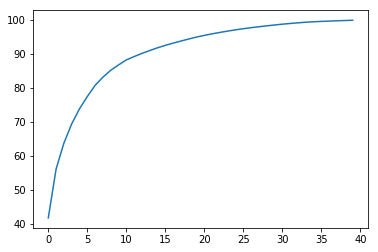

In [38]:
plt.plot(var1)

In the above graph, X is principle components, y is showing the cumulative variance explained
Because of this, I will move forward with 9 components

In [166]:
pca = PCA(n_components=3, random_state=7)

In [167]:
X_pca = pca.fit_transform(X_scaled)

In [197]:
kmeans = KMeans(n_clusters = 5,random_state=7, n_jobs=-1)
kmeans_more = KMeans(n_clusters = 14,random_state=7, n_jobs=-1)

In [201]:
kmeans.fit_transform(X_pca)

array([[ 4.40044191,  3.24866073,  9.3460095 ,  6.8911913 ,  6.73190322],
       [ 8.10134068,  8.50723003,  4.18897784, 10.58059409, 10.27502891],
       [ 4.07833309,  2.37341688, 12.06287403,  3.38520879,  2.80440771],
       ...,
       [ 5.69323904,  1.14939493, 12.80643875,  2.93596399,  4.6065569 ],
       [ 7.24295231,  3.58830863, 14.34393431,  0.55052464,  4.36883738],
       [ 4.32707204,  1.02579913, 11.32483142,  4.86613947,  5.12635485]])

In [198]:
kmeans_more.fit_transform(X_pca)

array([[ 4.82519463, 10.04922876,  3.42292682, ...,  8.73517253,
         8.97111617,  4.01899837],
       [ 8.99001183,  4.17843222,  8.21058952, ..., 11.85816894,
         4.66923768,  8.86351437],
       [ 2.37018937, 12.25233066,  3.58280759, ...,  4.47704419,
        12.0815391 ,  1.47207482],
       ...,
       [ 4.12653048, 13.1523109 ,  4.62235455, ...,  5.79297674,
        12.68517916,  1.66602145],
       [ 5.18233927, 14.43178949,  6.49445753, ...,  4.41557815,
        14.41815075,  3.27105166],
       [ 3.62565851, 11.85305567,  3.10355432, ...,  6.93743622,
        11.06868532,  1.97066438]])

In [202]:
labels = kmeans.labels_

In [203]:
labels_more = kmeans_more.labels_

In [204]:
#14 clusters with PCA at 3
silhouette_score(X_pca,labels_more, random_state=7)

0.2934967827337738

After a lot of tinkering, and using 10 PCA and 40 clusters with a silhouette score of .15 as my baseline, I think the mean score of each cluster at .387 is a much better judge of individual points belonging to their respective clusters, when I use PCA of 3 and 5 clusters.

In [205]:
#5 clusters with PCA at 3
silhouette_score(X_pca,labels, random_state=7)

0.3878826280164895

In [210]:
#new X dataframe for 14 clusters
X2 = X
X2['cluster'] = labels_more

In [208]:
#bringing the cluster labels back into the original X dataframe
X['cluster']=labels

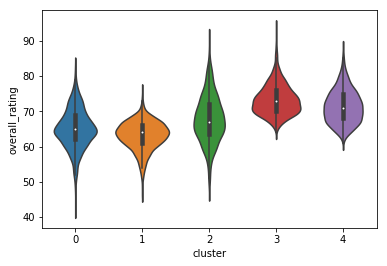

In [181]:
#showing distributions of overall rating in each cluster
sns.violinplot(x='cluster',y='overall_rating', data=X)

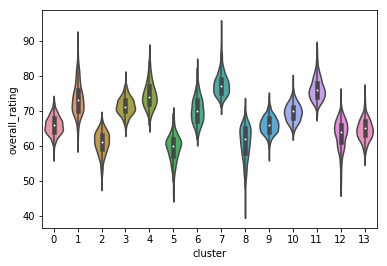

In [211]:
#showing distributions of overall rating in each cluster
sns.violinplot(x='cluster',y='overall_rating', data=X2)

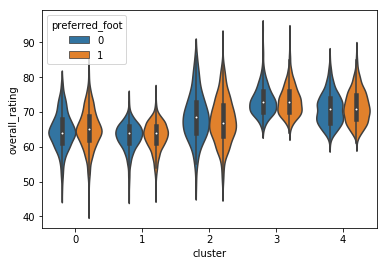

In [182]:
#I don't see a meaningful seperation of lefties vs righties in each cluster
sns.violinplot(x='cluster',y='overall_rating', data=X, hue = 'preferred_foot')

In [189]:
means = X.groupby('cluster').mean()
means

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,attacking_medium_rate,defensive_medium_rate
cluster,,,,,,,,,,,,,,,,,,,,,
0,65.099006,68.412219,0.752668,0.053736,0.195068,46.783217,31.831432,63.492823,58.327567,33.891592,...,64.768495,67.163047,63.905782,10.370997,10.805668,12.092381,10.914244,10.858668,0.692308,0.683842
1,63.163388,67.400427,0.775619,0.190095,0.025905,54.023972,58.442853,55.435192,60.490419,54.406694,...,32.337235,35.580816,33.948587,10.305734,11.124261,12.661964,11.137007,11.050780,0.664762,0.663619
2,67.858775,70.238837,0.867082,0.000000,0.000000,16.334372,15.815161,16.498442,28.042575,17.525677,...,15.931464,16.223261,17.313242,69.391485,66.013499,64.041537,67.551402,70.649013,0.902388,0.902388
3,73.348293,75.967317,0.760488,0.452195,0.080488,67.124390,69.565854,59.584878,71.418537,66.866325,...,31.279512,37.075122,33.562146,10.477073,10.804878,11.428293,10.663902,10.630732,0.471707,0.613659
4,71.460628,73.764510,0.700555,0.296858,0.292421,64.588170,49.885397,63.609982,71.218484,51.748153,...,66.687246,70.810721,67.784204,10.384104,10.971165,13.144917,11.032902,10.984843,0.555268,0.584843


In [212]:
means2 = X2.groupby('cluster').mean()
means2

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,attacking_medium_rate,defensive_medium_rate
cluster,,,,,,,,,,,,,,,,,,,,,
0,65.855689,68.672525,0.715079,0.155412,0.177613,58.366327,41.028677,60.646623,64.617021,43.337967,...,63.701203,66.662350,63.391011,10.437558,11.298797,14.308048,11.459759,11.542091,0.628122,0.644773
1,73.440835,75.498840,0.872390,0.000000,0.000000,15.682135,15.069606,15.795824,29.512761,17.562523,...,15.030162,15.433875,17.002075,74.914153,71.336427,68.846868,73.118329,76.433875,0.872390,0.872390
2,60.870930,65.341860,0.708140,0.079070,0.083721,52.090698,35.041860,56.986047,59.046512,36.810343,...,58.927907,61.724419,58.849754,10.040698,10.998837,12.959302,11.090698,10.959302,0.690698,0.739535
3,71.402908,74.119760,0.763045,0.396065,0.054748,64.377246,68.237810,59.706587,68.781865,64.977222,...,29.456801,34.617622,31.377740,10.584260,10.911035,11.562874,10.814371,10.701454,0.513259,0.612489
4,74.552100,76.674961,0.788491,0.125972,0.455677,57.762053,41.393468,71.314152,70.493002,44.055936,...,74.192846,77.222395,73.181026,10.500778,11.228616,13.922240,11.312597,11.343701,0.659409,0.424572
5,59.382920,65.108815,0.812672,0.114325,0.006887,46.654270,57.073003,54.338843,54.997245,50.487611,...,26.815427,29.487603,29.244366,10.250689,11.285124,12.603306,11.235537,11.119835,0.719008,0.670799
6,70.270208,72.326790,0.781755,0.019630,0.317552,42.636259,29.946882,71.230947,60.087760,31.578181,...,71.125866,72.898383,69.367716,10.602771,10.428406,10.857968,10.602771,10.748268,0.684758,0.607390
7,77.810084,80.169748,0.768067,0.576471,0.114286,72.284034,73.988235,60.789916,76.141176,71.971243,...,30.077311,37.196639,32.919964,10.443697,10.569748,10.875630,10.364706,10.472269,0.376471,0.594958
8,60.963602,65.214559,0.781609,0.013410,0.141762,36.111111,25.865900,60.852490,49.021073,28.256139,...,60.946360,63.963602,60.631115,10.273946,10.521073,10.783525,10.712644,10.172414,0.737548,0.775862


In [297]:
X_train, X_test, y_train, y_test = train_test_split(new_x, y, test_size=.2, random_state=7)

In [298]:
gbr = GradientBoostingRegressor(n_estimators=350)

In [299]:
model = gbr.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').